# Stanford CME 241 (Winter 2026) - Assignment 3

**Due: Friday, February 27 @ 11:59 PM PST on Gradescope.**

Assignment instructions:
- Make sure each of the subquestions have answers
- Ensure that group members indicate which problems they're in charge of
- Show work and walk through your thought process where applicable
- Empty code blocks are for your use, so feel free to create more under each section as needed
- Document code with light comments (i.e. 'this function handles visualization')

Submission instructions:
- When complete, fill out your publicly available GitHub repo file URL and group members below, then export or print this .ipynb file to PDF and upload the PDF to Gradescope.

*Link to this ipynb file in your public GitHub repo (replace below URL with yours):* 

https://github.com/my-username/my-repo/assignment-file-name.ipynb

*Group members (replace below names with people in your group):* 
- Person 1
- Person 2
- Person 3

## Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from typing import Iterable, Iterator, Mapping, TypeVar, Callable, Sequence, Tuple, Dict
from rl.distribution import Categorical
from rl.markov_process import FiniteMarkovRewardProcess
from rl.chapter10.prediction_utils import compare_td_and_mc
X = TypeVar('X')
S = TypeVar('S')

## Question 1: Milk Vendor Optimization Problem (Led by Lucas Tellez)

You are a milk vendor and your task is to bring to your store a supply (denoted $S \in \mathbb{R}$) of milk volume in the morning that will give you the best profits. You know that the demand for milk throughout the course of the day is a probability distribution function $f$ (for mathematical convenience, assume people can buy milk in volumes that are real numbers, hence milk demand $x \in \mathbb{R}$ is a continuous variable with a probability density function). 

For every extra gallon of milk you carry at the end of the day (supply $S$ exceeds random demand $x$), you incur a cost of $h$ (effectively the wasteful purchases amounting to the difference between your purchase price and the end-of-day discount disposal price since you are not allowed to sell the same milk the next day). For every gallon of milk that a customer demands that you don’t carry (random demand $x$ exceeds supply $S$), you incur a cost of $p$ (effectively the missed sales revenue amounting to the difference between your sales price and purchase price). 

Your task is to identify the optimal supply $S$ that minimizes your **Expected Cost** $g(S)$, given by:

$$
g_1(S) = \mathbb{E}[\max(x - S, 0)] = \int_{S}^{\infty} (x - S) \cdot f(x) \, dx
$$

$$
g_2(S) = \mathbb{E}[\max(S - x, 0)] = \int_{-\infty}^{S} (S - x) \cdot f(x) \, dx
$$

$$
g(S) = p \cdot g_1(S) + h \cdot g_2(S)
$$

---

### Part (A): Analytical Optimization

1. **Derive the first-order condition (FOC)** for minimizing the expected cost $g(S)$.
2. **Solve the FOC** to express the optimal supply $S^*$ in terms of the given parameters: $p$, $h$, and the demand distribution $f(x)$. (*Hint*: Pay attention to the balance between the costs of overstocking and understocking)

3. **Interpretation**: Provide an interpretation of the condition you derived. What does the balance between $p$ and $h$ imply about the optimal supply $S^*$?

---

### Part (B): Special Case Analysis

1. Consider the case where the demand $x$ follows an **exponential distribution** with parameter $\lambda > 0$. That is, $f(x) = \lambda e^{-\lambda x}$ for $x \geq 0$.
    - Derive an explicit expression for the optimal supply $S^*$.
    
2. Consider the case where the demand $x$ follows a **normal distribution** with mean $\mu$ and variance $\sigma^2$, i.e., $x \sim \mathcal{N}(\mu, \sigma^2)$. 
    - Set up the integral for $g(S)$ and describe how it relates to the **cumulative distribution function (CDF)** of the normal distribution.
    - Provide an interpretation of how changes in $\mu$ and $\sigma$ influence the optimal $S^*$. 

---

### Part (C): Framing as a Financial Options Problem

1. Frame the milk vendor’s problem as a **portfolio of call and put options**:
    - Identify the analog of the “strike price” and “underlying asset.”
    - Explain which part of the cost function $g_1(S)$ or $g_2(S)$ corresponds to a call option and which part to a put option.
    - What do $p$ and $h$ represent in this options framework?

2. Explain how this framing could be used to derive the optimal supply $S^*$ if solved using financial engineering concepts.

---

### Part (D): Numerical Solution and Simulation

1. **Numerical Solution**: Write a Python function that numerically estimates the optimal $S^*$ using an iterative search or numerical optimization method. 

2. **Simulation**: Generate random samples of milk demand from an exponential distribution and simulate the total costs for different values of $S$. Plot the costs against $S$ and visually identify the optimal $S$.

### Part (A) Answer

$$g_2'(S) = -Sf(S) + \int\limits_{-\infty}^S f(x)dx + Sf(S) = \int\limits_{-\infty}^S f(x)dx$$ It follows that $$g'(S) = h\int\limits_{-\infty}^S f(x)dx - p\int\limits_S^\infty f(x)dx = h -(p+h)\int\limits_S^\infty f(x)dx$$ It follows that the first order optimality condition for minimizing the expected cost is $$\frac{h}{p+h} = \int\limits_{S^*}^\infty f(x)dx$$ The optimal supply $S^*$ must be so that the probability of customer supply exceeding $S^*$ is equal to the ratio of the waste cost $h$ to the total sum $p+h$.

### Part (B) Answer

We solve the FOC in the special case as $$\frac{h}{p+h} = e^{-\lambda S^*} \implies \log h - \log(p+h) = -\lambda S^* \implies \lambda \log(p+h) - \lambda \log h = S^*$$ In the normal case the FOC turns to $$\frac{p}{p+h} = \Phi\bigg(\frac{S^* - \mu}{\sigma}\bigg) \iff \mu + \sigma\Phi^{-1}\bigg(\frac{p}{p+h}\bigg) = S^*$$ where $\Phi$ is the standard normal CDF. Clearly $S^*$ is linearly increasing in $\mu$. It also depends linearly on $\sigma$, but wheter it is increasing or decreasing depends on whether $p > h$ (increasing) or $p < h$ (decreasing).

### Part (C) Answer

This can be thought of as the expected cost of a portfolio of a short call option giving the right to buy $p$ fractional shares of customer demand at a strike price $S$ and a short put option giving the right to sell $h$ fractional shares of customer demand at a strike price $S$. We could solve for the optimal supply $S^*$ by minimizing the expected cost of the portfolio with respect to the strike price.

### Part (D) Answer

In [4]:
'''
fill in the code below, and then run the code in the next cell for the simulation
'''

# simulation parameters
p = 5  # Cost of understocking (per unit)
h = 2  # Cost of overstocking (per unit)
lambda_param = 1.0  # Parameter for exponential distribution

# Probability density function for demand
def demand_pdf(x):
    return lambda_param * np.exp(- lambda_param * x)

# Cumulative distribution function for demand
def demand_cdf(x):
    return 1.0 - np.exp(- lambda_param * x)

# Expected cost function g(S)
def expected_cost(S):
    # g1(S): Understocking cost
    g1 = S * np.exp(- lambda_param * S) + (1.0 / lambda_param - S) * (1.0 - demand_cdf(S))
    
    # g2(S): Overstocking cost (integral using CDF)
    g2 = S * demand_cdf(S) + (S * demand_pdf(S) - demand_cdf(S)) / lambda_param
    
    return g1 + g2

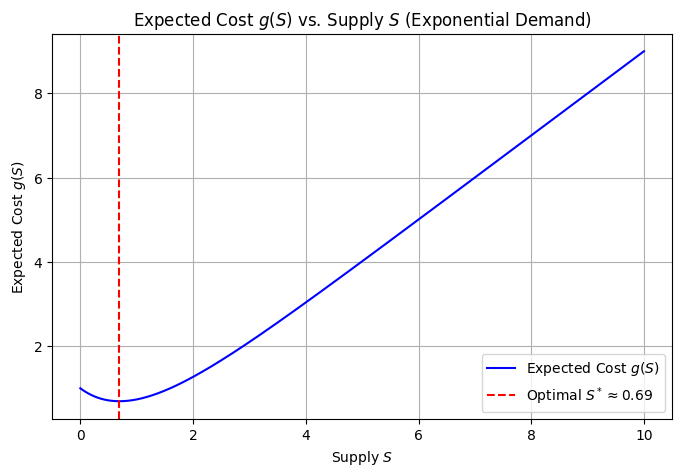

np.float64(0.693147155779346)

In [5]:
result = minimize_scalar(expected_cost, bounds=(0, 10), method='bounded')
optimal_S = result.x

# Simulation of costs
S_values = np.linspace(0, 10, 500)
costs = [expected_cost(S) for S in S_values]

# Plotting the costs against S
plt.figure(figsize=(8, 5))
plt.plot(S_values, costs, label="Expected Cost $g(S)$", color='blue')
plt.axvline(optimal_S, color='red', linestyle='--', label=f"Optimal $S^* \\approx {optimal_S:.2f}$")
plt.xlabel("Supply $S$")
plt.ylabel("Expected Cost $g(S)$")
plt.title("Expected Cost $g(S)$ vs. Supply $S$ (Exponential Demand)")
plt.legend()
plt.grid(True)
plt.show()

optimal_S

## Question 2: Car Sales (Led By: Lucas Tellez)

You must sell your car within a finite window of $N$ days. At the beginning of each day $t \in \{1, \dots, N\}$, you receive a single offer $X_t$ from a dealership, where $\{X_t\}$ are i.i.d. draws from a known continuous distribution $Q$ supported on $[m, M]$, with $0 < m < M$.

After observing $X_t$, you must immediately choose whether to **accept** or **reject** the offer:

- If you **accept** on day $t$, you sell the car immediately and receive payoff $X_t$. The process then terminates.
- If you **reject** on day $t < N$, you keep the car, pay a parking cost $c \ge 0$ at the end of that day, and proceed to day $t+1$.
- On day $N$, you must accept the offer (i.e., rejecting is not allowed).

Your objective is to maximize the expected **net payoff**, defined as the sale price minus the total parking costs paid before the sale.

---

### Part (A): MDP Modeling

Model this problem as a finite-horizon **Markov Decision Process (MDP)**. Clearly specify:

1. **States**
2. **Actions**
3. **Rewards**
4. **State-transition probabilities**
5. **Discount factor** (use $\gamma = 1$)

Also state whether this MDP is finite- or infinite-horizon, episodic or continuing, and whether it is time-homogeneous.

---

### Part (B): Structure of the Optimal Policy

Let $V_t$ denote the optimal value function when there are $t$ days remaining (before observing the offer).

1. Write down the Bellman recursion for $V_t$.
2. Show that the optimal policy is a **time-dependent threshold policy**: that is, there exists a reservation price $r_t$ such that it is optimal to accept an offer $x$ if and only if $x \ge r_t$.
3. Express the threshold $r_t$ in terms of $V_{t-1}$ and $c$.

(You may leave expectations with respect to $Q$ written in integral or expectation form. A closed-form solution for general $Q$ is not required.)

---

### Part (C): Special Case (No Integrals)

Now consider the special case where $c = 0$ and $Q = \text{Uniform}[m, M]$.

1. Write the recursion for $V_t$ explicitly.
2. Provide the optimal policy in as closed-form a way as possible. Your policy may depend on recursively defined coefficients, but your final expressions should contain **no integrals**.


### Part (A) Answer

The states can be represented by either the tuple $(t,X_t)$ where $t \in \{1,...,N\}$ is the day and $X_t\in [m,M]$ is the offer price or the null state $\kappa$ indicating we have terminated. The actions on a nonterminal state $s$ are boolean, encoded as 0 to hold and 1 to sell. The rewards are given by $$R(t,X_t,a) = \begin{cases}
-c : & t < N \ \text{ and } \ a = 0\\
X_t : & t = N \ \text{ or } \ a = 1
\end{cases}$$ The transition probabilities are given by 
$$p(t+1,X_{t+1} \in A,0,t,X_t) = P_Q(A) $$and$$p(\kappa,a,s) = \begin{cases}1 : & a = 0 \text{ or } s = \kappa\\
0: & \text{otherwise} \end{cases}$$ The MDP is finite-horizon and is not time-homogeneous since it is finite-horizon.

### Part (B) Answer

The Bellman recursion is $$V_t^*(x) = \max\bigg(x,\mathbb E[V_{t+1}^*(X_{t+1})] - c\bigg)$$ Since the optimal deterministic policy is simply the argmax of the optimal value function as above, it is immediately obvious that for $t < N$ it is optimal to accept if and only if $$X_t \geq r_t := \mathbb E[V_{t+1}^*(X_{t+1})] - c$$

### Part (C) Answer

In this special case we have by the above recursion $$V_t^*(x) = \max\bigg(x,\frac{1}{M-m}\int\limits_m^M V_{t+1}^*(y)dy\bigg)$$ To further simplify this we look at the case $t=N$ and see that we must have $$V_N^*(x) = x \implies r_N := \mathbb E[V_N^*(X_N)] = \frac{1}{M-m}\int\limits_m^M xdx = \frac{M^2 - m^2}{2(M-m)} = \frac{M+m}{2}$$ This induces the recursively defined sequence of coefficients $r_n$ with $r_N = \frac{M+m}{2}$ and $$r_t = \frac{r_{t+1}(r_{t+1} - m)}{M+m} + \frac{M^2 - r_{t+1}^2}{2(M+m)} = \frac{r_{t+1}^2 - 2mr_{t+1} + M^2}{2(M+m)}$$ which yields the optimal deterministic policy and value function as $$V_t^*(x) = \max(x,r_t) \  \text{ and } \ \pi_t(x) = \begin{cases} \text{sell} : & x \geq r_t \\ \text{hold} : & x < r_t \end{cases}$$

## Question 3: Constrained Consumption (Led By: Jordan Rothkowitz)

Consider the following discrete-time MDP for constrained consumption. At $t = 0$, the agent is given a finite amount $x_0 \in \mathbb{R}^+$ of a resource. In each time period, the agent can choose to consume any amount of the resource, with the consumption denoted as $c \in [0, x]$ where $x$ is the amount of the resource remaining at the start of the time period. This consumption results in a reduction of the resource at the start of the next time period:  
$$
x' = x - c.
$$  

Consuming a quantity $c$ of the resource provides a utility of consumption equal to $U(c)$, and we adopt the **CRRA utility function**:  
$$
U(c) = \frac{c^{1 - \gamma}}{1 - \gamma}, \quad (\gamma > 0, \gamma \neq 1)
$$

Our goal is to maximize the aggregate discounted utility of consumption until the resource is completely consumed. We assume a discount factor of $\beta \in (0, 1)$ when discounting the utility of consumption over any single time period. Assume parameters are such that the value function is finite.

We model this as a **discrete-time, continuous-state-space, continuous-action-space, stationary, deterministic MDP**, and so our goal is to solve for the **Optimal Value Function** and associated **Optimal Policy**, which will give us the optimal consumption trajectory of the resource. Since this is a stationary MDP, the **State** is simply the amount $x$ of the resource remaining at the start of a time period. The **Action** is the consumption quantity $c$ in that time period. The **Reward** for a time period is $U(c)$ when the consumption in that time period is $c$. The discount factor over each single time period is $\beta$.

We assume that the **Optimal Policy** is given by:  
$$
c^* = \theta^* \cdot x \quad \text{for some } \theta^* \in [0, 1].
$$

---

### Part (A): Closed-form Expression for $V_\theta(x)$

Our first step is to consider a fixed deterministic policy, given by:  
$$
c = \theta \cdot x \quad \text{for some fixed } \theta \in [0, 1].
$$  
Derive a closed-form expression for the **Value Function** $V_\theta(x)$ for a fixed deterministic policy, given by $c = \theta \cdot x$. Specifically, you need to express $V_\theta(x)$ in terms of $\beta$, $\gamma$, $\theta$, and $x$.

---

### Part (B): Solving for $\theta^*$

Use this closed-form expression for $V_\theta(x)$ to solve for the $\theta^*$ which maximizes $V_\theta(x)$ (thus fetching us the **Optimal Policy** given by $c^* = \theta^* \cdot x$).

---

### Part (C): Expression for $V^*(x)$

Use this expression for $\theta^*$ to obtain an expression for the **Optimal Value Function** $V^*(x)$ in terms of only $\beta$, $\gamma$, and $x$.

---

### Part (D): Validation of the Bellman Equation

Validate that the **Optimal Policy** (derived in part B) and **Optimal Value Function** (derived in part C) satisfy the **Bellman Optimality Equation**.

### Part (A) Answer

Under the fixed stationary policy $c_t=\theta\cdot x_t$, we have 
$$
\begin{align*}
x_{t+1} &= x_t - c_t\\
&= x_t - \theta x_t\\
&= x_t (1 - \theta)\\
x_t &= (1 - \theta)^t x
\end{align*}
$$
and thus consumption at time $t$ is 
$$
c_t = \theta (1 - \theta)^t x
$$
and utility per period is 
$$
U(c_t) = \frac{(\theta (1 - \theta)^t x)^{1-\gamma}}{1-\gamma} = \frac{\theta^{1-\gamma}(1-\theta)^{t(1-\gamma)}x^{1-\gamma}}{1-\gamma}.
$$
The value function is then the discounted sum
$$
\begin{align*}
V_\theta(x) &= \sum_{t=0}^\infty \beta^t U(c_t) \\
&= \sum_{t=0}^\infty \beta^t \frac{\theta^{1-\gamma}(1-\theta)^{t(1-\gamma)}x^{1-\gamma}}{1-\gamma}\\
&= \frac{\theta^{1-\gamma}x^{1-\gamma}}{1-\gamma}\sum_{t=0}^\infty (\beta(1-\theta)^{1-\gamma})^t
\end{align*}
$$
Assuming that this geometric series converges, we get that 
$$
V_\theta(x) = \frac{\theta^{1-\gamma}x^{1-\gamma}}{1-\gamma}\frac{1}{1-\beta(1-\theta)^{1-\gamma}}.
$$
For the edge case $\theta=1$, we consume everything in the first period since the policy is $c=x$. Thus only one reward is ever received, so $V_1(x) = U(x) = \frac{x^{1-\gamma}}{1-\gamma}$. In the other edge case $\theta=0$, we never consume anything, so the reward depends on how $U(0)$ is defined, i.e. the utility of consuming nothing.


### Part (B) Answer

Ignoring the edge cases, note that maximizing $V_\theta(x) = \frac{x^{1-\gamma}}{1-\gamma}\frac{\theta^{1-\gamma}}{1-\beta(1-\theta)^{1-\gamma}}$ over $\theta$ is the same as maximizing 
$$
f(\theta) := \frac{\theta^{1-\gamma}}{1-\beta(1-\theta)^{1-\gamma}}
$$ 
because the first fraction doesn't depend on $\theta$. Let $a=1-\gamma$ such that $a\neq 0$, then we can maximize this via high school single variable calculus.
$$
\begin{align*}
f'(\theta) = \frac{a\theta^{a-1}(1-\beta(1-\theta)^a)- \theta^a(\beta a(1-\theta)^{a-1})}{(1-\beta(1-\theta)^a)^2}&= 0\\
a\theta^{a-1}(1-\beta(1-\theta)^a)- \theta^a(\beta a(1-\theta)^{a-1}) &= 0\\
a\theta^{a-1}(1-\beta(1-\theta)^a) &= \theta^a(\beta a(1-\theta)^{a-1})\\
1-\beta(1-\theta)^a &= \theta(\beta (1-\theta)^{a-1})\\
\beta(1-\theta)^a + \theta(\beta (1-\theta)^{a-1}) &= 1\\
\beta(1-\theta)^{a-1}((1-\theta) + \theta) &= 1\\
\beta(1-\theta)^{a-1} &= 1\\
\beta(1-\theta)^{-\gamma} &= 1\\
\beta &= (1-\theta)^\gamma\\
\beta^{1/\gamma} &= 1-\theta\\
1-\beta^{1/\gamma} &= \theta^*
\end{align*}
$$
Since $\beta\in (0,1)$ and $\gamma>0$, we have $\beta^{1/\gamma}\in (0,1)$, thus $\theta^* \in (0,1)$ and $c^* = (1-\beta^{1/\gamma}) x$.

### Part (C) Answer

From part (a), 
$$
V_\theta(x) = \frac{\theta^{1-\gamma}x^{1-\gamma}}{(1-\gamma)(1-\beta(1-\theta)^{1-\gamma})}.
$$
Plugging in $\theta^*=1-\beta^{1/\gamma}$,
$$
\begin{align*}
V^*_\theta(x) &= \frac{(1-\beta^{1/\gamma})^{1-\gamma}x^{1-\gamma}}{(1-\gamma)(1-\beta(\beta^{1/\gamma})^{1-\gamma})}\\
&= \frac{(1-\beta^{1/\gamma})^{1-\gamma}x^{1-\gamma}}{(1-\gamma)(1-\beta^{1/\gamma})}\\
&= \frac{x^{1-\gamma}}{1-\gamma} (1-\beta^{1/\gamma})^{-\gamma}
\end{align*}
$$

### Part (D) Answer

The Bellman optimality equation for this problem is
$$
V^*(x) = \max_{c \in [0,x]} \left\{ U(c) + \beta V^*(x-c) \right\},
\qquad
U(c) = \frac{c^{1-\gamma}}{1-\gamma}.
$$

From Part (C), the candidate optimal value function is
$$
V^*(x) = A \, \frac{x^{1-\gamma}}{1-\gamma},
\quad\text{where}\quad
A := (1-\beta^{1/\gamma})^{-\gamma}.
$$

First, we substitute the candidate value function into the Bellman RHS. For any feasible $ c \in [0,x] $,
$$
U(c) + \beta V^*(x-c)
= \frac{c^{1-\gamma}}{1-\gamma}
+ \beta A \frac{(x-c)^{1-\gamma}}{1-\gamma}.
$$

Thus the Bellman problem becomes
$$
\max_{c \in [0,x]}
\frac{1}{1-\gamma}
\left(
c^{1-\gamma} + \beta A (x-c)^{1-\gamma}
\right).
$$

Since the factor $\frac{1}{1-\gamma}$ does not depend on $c$, the maximizer is the same as for
$$
\max_{c \in [0,x]}
\Phi(c)
:= c^{1-\gamma} + \beta A (x-c)^{1-\gamma}.
$$

Next, we differentiate $ \Phi(c) $:
$$
\Phi'(c)
= (1-\gamma)c^{-\gamma}
- (1-\gamma)\beta A (x-c)^{-\gamma}.
$$

Setting the first-order condition $ \Phi'(c)=0 $ (interior solution):
$$
c^{-\gamma} = \beta A (x-c)^{-\gamma}.
$$

Rearranging,
$$
\left( \frac{x-c}{c} \right)^\gamma = \beta A,
$$
so
$$
\frac{x-c}{c} = (\beta A)^{1/\gamma}.
$$

Hence,
$$
x = c \left( 1 + (\beta A)^{1/\gamma} \right),
\qquad
c = \frac{x}{1 + (\beta A)^{1/\gamma}}.
$$

Now compute $ (\beta A)^{1/\gamma} $
$$
(\beta A)^{1/\gamma}
= \beta^{1/\gamma} A^{1/\gamma}
= \beta^{1/\gamma} (1-\beta^{1/\gamma})^{-1}
= \frac{\beta^{1/\gamma}}{1-\beta^{1/\gamma}}.
$$

Therefore,
$$
1 + (\beta A)^{1/\gamma}
= \frac{1}{1-\beta^{1/\gamma}},
$$
and the optimal consumption rule is
$$
c^*(x) = (1-\beta^{1/\gamma}) x.
$$

This coincides with the optimal policy derived in Part (b):
$$
\theta^* = 1-\beta^{1/\gamma}.
$$

Next, we will verify that the maximized RHS equals $V^*(x)$. With $ c^* = \theta^* x$ and $x-c^* = (1-\theta^*)x = \beta^{1/\gamma} x$, we have
$$
U(c^*) + \beta V^*(x-c^*)
= \frac{(\theta^* x)^{1-\gamma}}{1-\gamma}
+ \beta A \frac{(\beta^{1/\gamma} x)^{1-\gamma}}{1-\gamma}.
$$

Factor out $ \frac{x^{1-\gamma}}{1-\gamma} $:
$$
= \frac{x^{1-\gamma}}{1-\gamma}
\left(
(\theta^*)^{1-\gamma}
+ \beta A \beta^{(1-\gamma)/\gamma}
\right).
$$

Since $ \beta \cdot \beta^{(1-\gamma)/\gamma} = \beta^{1/\gamma} $,
$$
= \frac{x^{1-\gamma}}{1-\gamma}
\left(
(\theta^*)^{1-\gamma}
+ A \beta^{1/\gamma}
\right).
$$

Substitute $ \theta^* = 1-\beta^{1/\gamma} $ and $ A = (1-\beta^{1/\gamma})^{-\gamma} $:
$$
(\theta^*)^{1-\gamma} = (1-\beta^{1/\gamma})^{1-\gamma},
$$
$$
A \beta^{1/\gamma} = (1-\beta^{1/\gamma})^{-\gamma} \beta^{1/\gamma}.
$$

Factor out $ (1-\beta^{1/\gamma})^{-\gamma} $:
$$
(1-\beta^{1/\gamma})^{1-\gamma}
= (1-\beta^{1/\gamma})^{-\gamma}(1-\beta^{1/\gamma}),
$$
so
$$
(\theta^*)^{1-\gamma} + A \beta^{1/\gamma}
= (1-\beta^{1/\gamma})^{-\gamma}
\left(
(1-\beta^{1/\gamma}) + \beta^{1/\gamma}
\right)
= (1-\beta^{1/\gamma})^{-\gamma}.
$$

Therefore,
$$
U(c^*) + \beta V^*(x-c^*)
= \frac{x^{1-\gamma}}{1-\gamma}(1-\beta^{1/\gamma})^{-\gamma}
= V^*(x).
$$


Hence, the derived policy and value function are indeed optimal.

## Problem 4: Double Q-Learning (Led By: Jordan Rothkowitz)

It is known that **Q-Learning** can suffer from maximization bias during finite-sample training. In this problem, we consider a modification of tabular Q-Learning called **Double Q-Learning**, which reduces this bias by decoupling action selection and evaluation.

---

### **Algorithm 1: Double Q-Learning**

**Initialize** $Q_1(s,a)$ and $Q_2(s,a)$ for all $s \in \mathcal{S}$, $a \in \mathcal{A}$  
**yield** estimate of $Q$

**while** True **do**  
&emsp; **select** initial state $s_0$, set $t = 0$  
&emsp; **while** $s_t$ is non-terminal **do**  

&emsp;&emsp; **select** $a_t$ using $\epsilon$-greedy with respect to  
&emsp;&emsp; $\displaystyle \pi(s) = \arg\max_a \big( Q_1(s,a) + Q_2(s,a) \big)$  

&emsp;&emsp; **observe** $(r_t, s_{t+1})$  

&emsp;&emsp; **with probability 0.5 update $Q_1$:**

&emsp;&emsp;&emsp; Let  
&emsp;&emsp;&emsp; $\displaystyle a^* = \arg\max_a Q_1(s_{t+1}, a)$  

&emsp;&emsp;&emsp; Update  
&emsp;&emsp;&emsp; $\displaystyle Q_1(s_t, a_t) \leftarrow Q_1(s_t, a_t) + \alpha \Big(r_t + \gamma Q_2(s_{t+1}, a^*)- Q_1(s_t, a_t)\Big)$

&emsp;&emsp; **otherwise update $Q_2$:**

&emsp;&emsp;&emsp; Let  
&emsp;&emsp;&emsp; $\displaystyle a^* = \arg\max_a Q_2(s_{t+1}, a)$  

&emsp;&emsp;&emsp; Update  
&emsp;&emsp;&emsp; $\displaystyle Q_2(s_t, a_t) \leftarrow Q_2(s_t, a_t)+ \alpha \Big(r_t + \gamma Q_1(s_{t+1}, a^*)- Q_2(s_t, a_t)\Big)$

&emsp;&emsp; $t \leftarrow t + 1$  
&emsp;&emsp; $s_t \leftarrow s_{t+1}$  

**yield** estimate $Q_1 + Q_2$

---

### **Algorithm 2: Q-Learning**

**Initialize** $Q(s,a)$ for all $s \in \mathcal{S}$, $a \in \mathcal{A}$  
**yield** $Q$

**while** True **do**  
&emsp; **select** initial state $s_0$, set $t = 0$  
&emsp; **while** $s_t$ is non-terminal **do**  

&emsp;&emsp; **select** $a_t$ using $\epsilon$-greedy with respect to  
&emsp;&emsp; $\displaystyle \pi(s) = \arg\max_a Q(s,a)$  

&emsp;&emsp; **observe** $(r_t, s_{t+1})$  

&emsp;&emsp; Update  
&emsp;&emsp; $\displaystyle Q(s_t, a_t) \leftarrow Q(s_t, a_t)+ \alpha \Big(r_t + \gamma \max_a Q(s_{t+1}, a)- Q(s_t, a_t)\Big)$

&emsp;&emsp; $t \leftarrow t + 1$  
&emsp;&emsp; $s_t \leftarrow s_{t+1}$  

**yield** $Q$

---

### Instructions

The code skeleton for this problem is provided below. Implement the functions:

- `double_q_learning`
- `q_learning`

After running both algorithms, you will obtain a plot of the estimated Q-value versus episode number.

In your writeup:

1. Compare the behavior of Q-Learning and Double Q-Learning.
2. Explain why Q-Learning can exhibit maximization bias.
3. Discuss the advantages and possible drawbacks of Double Q-Learning in general MDPs.


In [7]:
import random
import numpy as np
import matplotlib.pyplot as plt

from dataclasses import dataclass
from collections import defaultdict
from typing import Mapping, Iterator, TypeVar, Tuple, Dict, Iterable, Generic

# RL imports (adapt or remove if you don't have the same environment):
from rl.distribution import (
    Distribution, Constant, Gaussian, Choose, SampledDistribution, Categorical
)
from rl.markov_process import NonTerminal, State, Terminal
from rl.markov_decision_process import MarkovDecisionProcess
from rl.td import epsilon_greedy_action

S = TypeVar('S')
A = TypeVar('A')

In [8]:
# -----------------------------------------------------------------------
# Tabular Q-value function approximation (done for you)
# -----------------------------------------------------------------------
class TabularQValueFunctionApprox(Generic[S, A]):
    """
    A basic implementation of a tabular function approximation 
    with constant learning rate of 0.1
    Also tracks the number of updates per (state, action).
    """
    def __init__(self):
        self.counts: Mapping[Tuple[NonTerminal[S], A], int] = defaultdict(int)
        self.values: Mapping[Tuple[NonTerminal[S], A], float] = defaultdict(float)
    
    def update(self, k: Tuple[NonTerminal[S], A], target: float) -> None:
        alpha = 0.1
        old_val = self.values[k]
        self.values[k] = (1 - alpha) * old_val + alpha * target
        self.counts[k] += 1
    
    def __call__(self, x: Tuple[NonTerminal[S], A]) -> float:
        return self.values[x]

In [9]:
# -----------------------------------------------------------------------
# Double Q-Learning (fill in)
# -----------------------------------------------------------------------
def double_q_learning(
    mdp: MarkovDecisionProcess[S, A],
    states: Distribution[NonTerminal[S]],
    gamma: float
) -> Iterator[TabularQValueFunctionApprox[S, A]]:
    """
    Implements Double Q-Learning as described:
      1) We keep two Q-tables, Q1 and Q2.
      2) We choose actions epsilon-greedily with respect to Q1+Q2.
      3) With 50% chance we update Q1 using next-action chosen by max of Q2,
         otherwise update Q2 using next-action chosen by max of Q1.
    """
    Q1 = TabularQValueFunctionApprox[S, A]()
    Q2 = TabularQValueFunctionApprox[S, A]()
    epsilon = 0.1

    def combined_q_value(nt_state: NonTerminal[S], action: A) -> float:
        return Q1((nt_state, action)) + Q2((nt_state, action))

    def argmax_over_actions(
        nt_state: NonTerminal[S],
        q_table: TabularQValueFunctionApprox[S, A]
    ) -> A:
        actions = list(mdp.actions(nt_state))
        # assume non-empty
        best_a = actions[0]
        best_v = q_table((nt_state, best_a))
        for a in actions[1:]:
            v = q_table((nt_state, a))
            if v > best_v:
                best_v = v
                best_a = a
        return best_a

    def make_combined_table() -> TabularQValueFunctionApprox[S, A]:
        Q = TabularQValueFunctionApprox[S, A]()
        keys = set(Q1.values.keys()) | set(Q2.values.keys())
        for k in keys:
            Q.values[k] = Q1.values.get(k, 0.0) + Q2.values.get(k, 0.0)
            Q.counts[k] = Q1.counts.get(k, 0) + Q2.counts.get(k, 0)
        return Q

    # initial estimate
    yield make_combined_table()

    while True:
        state = states.sample()  # NonTerminal[S]

        while isinstance(state, NonTerminal):
            actions_set = set(mdp.actions(state))

            # epsilon-greedy wrt Q1+Q2
            greedy_action = max(
                ((a, combined_q_value(state, a)) for a in actions_set),
                key=lambda t: t[1]
            )[0]
            action = Categorical({
                a: epsilon / len(actions_set) +
                   (1 - epsilon if a == greedy_action else 0.0)
                for a in actions_set
            }).sample()

            next_state, reward = mdp.step(state, action).sample()

            if random.random() < 0.5:
                # update Q1, choose with Q1, evaluate with Q2
                if isinstance(next_state, NonTerminal):
                    a_star = argmax_over_actions(next_state, Q1)
                    target = reward + gamma * Q2((next_state, a_star))
                else:
                    target = reward
                Q1.update((state, action), target)
            else:
                # update Q2, choose with Q2, evaluate with Q1
                if isinstance(next_state, NonTerminal):
                    a_star = argmax_over_actions(next_state, Q2)
                    target = reward + gamma * Q1((next_state, a_star))
                else:
                    target = reward
                Q2.update((state, action), target)

            state = next_state

        # yield after each episode
        yield make_combined_table()

In [10]:
# -----------------------------------------------------------------------
# Standard Q-Learning (fill in)
# -----------------------------------------------------------------------
def q_learning(
    mdp: MarkovDecisionProcess[S, A],
    states: Distribution[NonTerminal[S]],
    gamma: float
) -> Iterator[TabularQValueFunctionApprox[S, A]]:
    """
    Standard Q-Learning:
      1) Keep one Q table
      2) Epsilon-greedy wrt that table
      3) Update Q((s,a)) with  r + gamma * max_{a'} Q((s_next, a'))
    """
    Q = TabularQValueFunctionApprox[S, A]()
    epsilon = 0.1

    # initial estimate
    yield Q

    while True:
        state = states.sample()  # NonTerminal[S]

        while isinstance(state, NonTerminal):
            action = epsilon_greedy_action(
                q=Q,
                nt_state=state,
                actions=set(mdp.actions(state)),
                ϵ=epsilon
            )
            next_state, reward = mdp.step(state, action).sample()

            if isinstance(next_state, NonTerminal):
                next_return = max(
                    Q((next_state, a)) for a in mdp.actions(next_state)
                )
                target = reward + gamma * next_return
            else:
                target = reward

            Q.update((state, action), target)
            state = next_state

        # yield after each episode
        yield Q

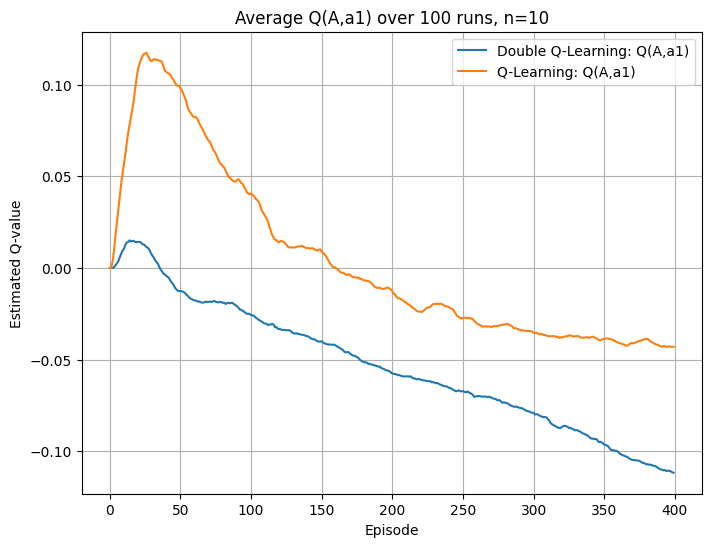

In [11]:
# -----------------------------------------------------------------------
# The MDP: States A,B and actions a1,a2,b1,...,bn (don't modify anything anymore, just run to get the graphs)
# -----------------------------------------------------------------------
@dataclass(frozen=True)
class P1State:
    """
    The MDP state, storing whether we are in "A" or "B".
    """
    name: str

class P1MDP(MarkovDecisionProcess[P1State, str]):
    
    def __init__(self, n: int):
        self.n = n

    def actions(self, state: NonTerminal[P1State]) -> Iterable[str]:
        """
        Return the actions available from this state.
          - if state is A => ["a1", "a2"]
          - if state is B => ["b1", ..., "bn"]
        """
        if state.state.name == "A":
            return ["a1", "a2"]
        else:
            return [f"b{i}" for i in range(1, self.n+1)]
    
    def step(
        self,
        state: NonTerminal[P1State],
        action: str
    ) -> Distribution[Tuple[State[P1State], float]]:
        """
        Return the distribution of (next state, reward) from (state, action):
          - A + a1 => reward 0, next state B
          - A + a2 => reward 0, next state terminal
          - B + b_i => reward ~ Normal(-0.1,1), next state terminal
        """
        if state.state.name == "A":
            if action == "a1":
                return Constant((NonTerminal(P1State("B")), 0.0))
            else:
                return Constant((Terminal(P1State("T")), 0.0))
        else:
            # For B + b_i => reward ~ N(-0.1,1), then terminal
            def sampler():
                r = np.random.normal(loc=-0.1, scale=1.0)
                return (Terminal(P1State("T")), r)
            return SampledDistribution(sampler)

def run_double_q_once(mdp, start_dist, gamma=1.0, episodes=400):
    """
    Runs one 'chain' of Double Q-Learning for 'episodes' episodes,
    returning a list of Q-values for Q((A,a1)) at the end of each episode.
    """
    dq_iter = double_q_learning(mdp, start_dist, gamma)  # generator
    vals = []
    for _ in range(episodes):
        Q1 = next(dq_iter)
        # record Q1((A,a1)) each time
        qA1 = Q1((NonTerminal(P1State("A")), "a1"))
        vals.append(qA1)
    return vals

def run_q_once(mdp, start_dist, gamma=1.0, episodes=400):
    """
    Same but for standard Q-Learning
    """
    q_iter = q_learning(mdp, start_dist, gamma)
    vals = []
    for _ in range(episodes):
        Q = next(q_iter)
        qA1 = Q((NonTerminal(P1State("A")), "a1"))
        vals.append(qA1)
    return vals

def main():
    # For reproducibility
    random.seed(0)
    np.random.seed(0)

    n = 10
    mdp = P1MDP(n)
    # Always start in A, as a NonTerminal
    start_dist = Constant(NonTerminal(P1State("A")))

    N_RUNS = 100
    N_EPISODES = 400

    all_dbl = []
    all_std = []

    for _ in range(N_RUNS):
        dbl_vals = run_double_q_once(mdp, start_dist, gamma=1.0, episodes=N_EPISODES)
        std_vals = run_q_once(mdp, start_dist, gamma=1.0, episodes=N_EPISODES)
        all_dbl.append(dbl_vals)
        all_std.append(std_vals)

    arr_dbl = np.array(all_dbl)
    arr_std = np.array(all_std)

    avg_dbl = np.mean(arr_dbl, axis=0)
    avg_std = np.mean(arr_std, axis=0)

    plt.figure(figsize=(8,6))
    plt.plot(avg_dbl, label='Double Q-Learning: Q(A,a1)')
    plt.plot(avg_std, label='Q-Learning: Q(A,a1)')
    plt.xlabel('Episode')
    plt.ylabel('Estimated Q-value')
    plt.title('Average Q(A,a1) over 100 runs, n=10')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()

# Analysis 

This experiment visualizes the qualitative difference between Q-Learning and Double Q-Learning. Standard Q-Learning initially assigns a higher value to $Q(A,a_1)$, even though the true expected return of taking $a_1$ is negative. The estimate is pulled upward early in training and only gradually drifts downward. Double Q-Learning, by contrast, produces a much more conservative trajectory. Its estimates fluctuate less dramatically and settle closer to the true value. Intuitively, Q-Learning appears overly optimistic about the value of $a_1$, whereas Double Q-Learning corrects more quickly and avoids the large upward excursion.

Aside (why the expected return of action $a_1$ is negative): Taking $a_1$ from state $A$ yields an immediate reward of zero but deterministically transitions the agent to state $B$. From $B$, every available action terminates the episode with a reward drawn from a Normal distribution with mean $-0.1$. Since there is no further continuation value beyond that step, the expected return of reaching $B$ is simply $-0.1$. Therefore the expected return of choosing $a_1$ in $A$ is $0 + \gamma(-0.1)$, which is negative when $\gamma = 1$. Intuitively, $a_1$ commits the agent to entering a state where the average payoff is unfavorable, so its value must also be negative.


This behavior is a direct consequence of maximization bias. In Q-Learning the update target contains a term of the form $\max_a Q(s',a)$. Because the same noisy value estimates are used both to select the maximizing action and to evaluate its value, random positive errors are preferentially selected. Even if all actions have identical true values, the maximum over noisy estimates is biased upward in expectation. The algorithm therefore tends to overestimate action values, particularly in states with many actions or high reward variance. This bias then propagates backward through the value updates.

Double Q-Learning mitigates this effect by decoupling action selection from evaluation. One table determines which action looks best, while the other provides the value used in the target. This reduces the systematic upward bias and often leads to more stable learning, especially in noisy environments. The main advantage is therefore improved statistical accuracy of value estimates. The drawback is increased variance and slower learning in some settings, since each table is updated less frequently and the algorithm maintains two independent estimators. In small or low-noise problems the benefit may be modest, while the extra bookkeeping and data requirements remain.
